<a href="https://colab.research.google.com/github/schizohub/ML_projects/blob/main/digit_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from google.colab import files


In [2]:
#  files.upload()

In [3]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
!kaggle competitions download -c digit-recognizer

digit-recognizer.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
import zipfile
from pathlib import Path 

# 1. Create models directory
MODEL_PATH = Path('digit_recognizer')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
# MODEL_NAME = 'First_CNN_model.pth'
# MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

with zipfile.ZipFile("/content/digit-recognizer.zip", 'r') as zip_ref:
    zip_ref.extractall(MODEL_PATH)

In [6]:
train_data = pd.read_csv("/content/digit_recognizer/train.csv")
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
test_data = pd.read_csv("/content/digit_recognizer/test.csv")
test_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
train_data.label.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [9]:
arr = train_data.drop('label',axis=1).iloc[10].values

In [10]:
num_tensor = torch.from_numpy(arr).reshape(28,28)
# num_tensor[:10]

In [11]:
len(train_data)

42000

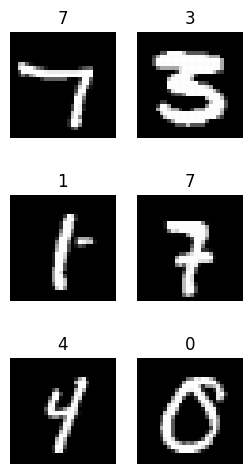

In [12]:
torch.manual_seed(42)
rows, cols= 3,2
def plot_random_imgs(train_img, class_name):
    train_img = torch.from_numpy(train_img).reshape(28,28)
    plt.imshow(train_img, cmap='gray')
    plt.axis(False)
    plt.title(class_name)

fig = plt.figure(figsize=(3,6))
class_names = train_data['label'].values
train = train_data.drop('label', axis=1)
for i in range(1, rows*cols+1):
    random_idx = torch.randint(1, len(train_data), size=[1]).item()
    # print(random_idx)
    img = train.iloc[random_idx].values
    fig.add_subplot(rows, cols, i)
    plot_random_imgs(img,class_names[random_idx])

In [13]:
# df.values.reshape(values.shape[0], 28,28)
train_data.label.value_counts().index.sort_values()

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')

In [14]:
class Tensorize():
    def __init__(self, dataframe):
        self.df = dataframe
    
    def get_values(self):
        df = self.df.drop('label',axis=1).values.reshape(self.df.shape[0], 28,28)
        new_value = []
        for index, values in enumerate(df):
            new_value.append([values, self.df['label'].values[index]])
        return tuple(new_value)

    def get_values_without_label(self):
        return self.df.values.reshape(self.df.shape[0], 28,28)
        
    def get_classes(self):
        return self.df.label.value_counts().index.sort_values().to_numpy()

In [15]:
totensor = Tensorize(train_data)
prepared_data = totensor.get_values()

In [167]:
test_tensor = Tensorize(test_data)
prepared_test_data = test_tensor.get_values_without_label()
prepared_test_data[0].shape

(28, 28)

In [17]:
img, label = (train_data.drop('label',axis=1),train_data['label'].values[0])

In [18]:
# prepared_test_data = Tensorize(test_data).get_values

In [19]:
img, label = prepared_data[0]
label

1

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(prepared_data, test_size=0.2, random_state=42)

In [21]:
len(X_train), len(X_test)

(33600, 8400)

In [22]:
import os
os.cpu_count()

2

In [23]:
from torch.utils.data import DataLoader
import os
BATCH_SIZE=32
train_dataloader = DataLoader(dataset=X_train,
                              batch_size=BATCH_SIZE,
                              shuffle=True, 
                              num_workers=os.cpu_count())
test_dataloader = DataLoader(dataset=X_test,
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             num_workers=os.cpu_count())

In [168]:
main_test_dataloader = DataLoader(dataset=prepared_test_data,
                                  batch_size=BATCH_SIZE,
                                  shuffle=False)

In [93]:
print(f"DataLoaders: {train_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}...")
print(f"Length of train_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}...")
print(f"Length of main test_dataloader: {len(main_test_dataloader)} batches of {BATCH_SIZE}...")

DataLoaders: <torch.utils.data.dataloader.DataLoader object at 0x7f357295ed30>
Length of train_dataloader: 1050 batches of 32...
Length of train_dataloader: 263 batches of 32...
Length of main test_dataloader: 875 batches of 32...


In [25]:
# X_train[:10].to(device)

In [26]:
features = next(iter(train_dataloader))[0] #.unsqueeze(dim=1).permute(1, 0,2,3)
features.shape

torch.Size([32, 28, 28])

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [28]:

# !pip install torchmetrics
# try:
#     import torchmetrics, mlxtend
#     print(f"The version of mlxtend: {mlxtend.__version__}")
#     assert int(mlxtend.__version__.split(".")[1])>=19, "mlxtend version should be 19 or higher"
# except:
#     !pip install -q torchmetrics -U mlxtend
#     import torchmetrics, mlxtend
#     print(f"The version of mlxtend: {mlxtend.__version__}")
     

In [29]:
from timeit import default_timer as timer 
from torchmetrics import Accuracy
def timer_fn(
    start: float,
    end: float,
    device: torch.device =None):
    total_time = end-start
    print(f"Total time of the process is {total_time:.3f} on the {device}")
    return total_time

def accuracy_fn(y_true, y_preds, device):
    accuracy = Accuracy(task='multiclass',num_classes=len(totensor.get_classes())).to(device)
    return accuracy(y_true, y_preds)

In [145]:
class TinyVGGModelV0(nn.Module):
    def __init__(self, input_features, hidden_units, output_features):
        super().__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_features,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            # nn.ReLU(),
            
            nn.Tanh(),
             nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            # nn.ReLU(),
           
            nn.Tanh(),
             nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_features)
        )

    def forward(self, x):
        return self.classifier(self.conv_block2(self.conv_block1(x)))

In [150]:
model_0 = TinyVGGModelV0(input_features=1,
                         hidden_units=10,
                         output_features=len(totensor.get_classes())).to(device)
model_0

TinyVGGModelV0(
  (conv_block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Tanh()
    (4): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Tanh()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Tanh()
    (4): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Tanh()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [32]:
model_0.parameters()

<generator object Module.parameters at 0x7f3570437510>

In [151]:
loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.CTCLoss()
# optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)
optimizer = torch.optim.Adadelta(params=model_0.parameters(), lr=0.3)

In [34]:
def train_loop(model: nn.Module,
               optimizer,
               loss_func,
               accuracy_func,
               train_data,
               device=None):
    train_loss, train_acc = 0,0
    model.train()
    for batch, (X,y) in enumerate(train_data):
        X, y = X.unsqueeze(dim=1).to(device).type(torch.float32), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        
        train_loss+=loss
        train_acc+=accuracy_func(y, y_pred.argmax(dim=1), device)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss/=len(train_data)
    train_acc/=len(train_data)

    print(f"Train_loss: {train_loss:.4f}, Train_acc: {train_acc:.2f}%")

def test_loop(model: nn.Module,
              loss_fn,
              accuracy_fn,
              test_data,
              device=None):
    test_loss, test_acc = 0,0
    model.eval()
    with torch.inference_mode():
        for batch, (X_test,y_test) in enumerate(test_data):
            X_test = X_test.unsqueeze(dim=1).to(device).type(torch.float32)

            y_test_preds = model(X_test)
            y_test = y_test.to(device)

            loss = loss_fn(y_test_preds, y_test)
            test_loss+=loss
            test_acc+=accuracy_fn(y_test, y_test_preds.argmax(dim=1),device)
        test_loss/=len(test_data)
        test_acc/=len(test_data)
        print(f"Test_loss: {test_loss:.4f}, Test_acc: {test_acc:.2f}%")


In [174]:
start_time_on_cpu = timer()
epochs = 10
for epoch in range(epochs):
    print(f"Epoch: {epoch}")

    train_loop(model=model_0,
               optimizer=optimizer,
               loss_func=loss_fn,
               accuracy_func=accuracy_fn,
               train_data=train_dataloader,
               device=device)
    
    test_loop(model=model_0,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              test_data=test_dataloader,
              device=device)
end_time_on_cpu = timer()
timed = timer_fn(start_time_on_cpu, end_time_on_cpu, device=device)


Epoch: 0
Train_loss: 0.0407, Train_acc: 0.99%
Test_loss: 0.0546, Test_acc: 0.98%
Epoch: 1
Train_loss: 0.0363, Train_acc: 0.99%
Test_loss: 0.0492, Test_acc: 0.98%
Epoch: 2
Train_loss: 0.0338, Train_acc: 0.99%
Test_loss: 0.0454, Test_acc: 0.99%
Epoch: 3
Train_loss: 0.0307, Train_acc: 0.99%
Test_loss: 0.0465, Test_acc: 0.99%
Epoch: 4
Train_loss: 0.0287, Train_acc: 0.99%
Test_loss: 0.0456, Test_acc: 0.99%
Epoch: 5
Train_loss: 0.0255, Train_acc: 0.99%
Test_loss: 0.0445, Test_acc: 0.99%
Epoch: 6
Train_loss: 0.0233, Train_acc: 0.99%
Test_loss: 0.0433, Test_acc: 0.98%
Epoch: 7
Train_loss: 0.0222, Train_acc: 0.99%
Test_loss: 0.0396, Test_acc: 0.99%
Epoch: 8
Train_loss: 0.0199, Train_acc: 0.99%
Test_loss: 0.0505, Test_acc: 0.98%
Epoch: 9
Train_loss: 0.0187, Train_acc: 0.99%
Test_loss: 0.0434, Test_acc: 0.99%
Total time of the process is 97.513 on the cuda


In [154]:

def make_predictions(model: torch.nn.Module,
                     data,
                     device: torch.device=device):
    pred_probs = []
    model.to(device).eval()

    with torch.inference_mode():
        for sample in data:
            #Adding extra dim and send the data into the target device
            sample = sample.unsqueeze(dim=0).to(device)

            #Forward pass 
            pred = model(sample)

            #Find out the max probability of the modelled data
            # pred_prob = torch.softmax(pred, dim=0)
            pred_prob = pred.argmax(dim=1)

            #Appending the results to the list
            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)

In [37]:
# X_test[0]

In [175]:
import random

test_samples = []
test_labels = []
for sample, label in random.sample(X_test, k=9):
    test_samples.append(torch.from_numpy(sample).unsqueeze(dim=0).type(torch.float32))
    test_labels.append(label)


In [39]:
test_samples[0].shape, test_labels

(torch.Size([1, 28, 28]), [6, 2, 5, 9, 4, 6, 6, 0, 2])

In [176]:
pred_probs = make_predictions(model_0,
                              test_samples,
                              device)
# pred_classes = pred_probs.argmax(dim=1)
pred_probs.T

tensor([[9, 3, 3, 0, 9, 0, 1, 1, 6]])

In [177]:
test_labels
pred_classes = pred_probs.T.squeeze()
pred_classes

tensor([9, 3, 3, 0, 9, 0, 1, 1, 6])

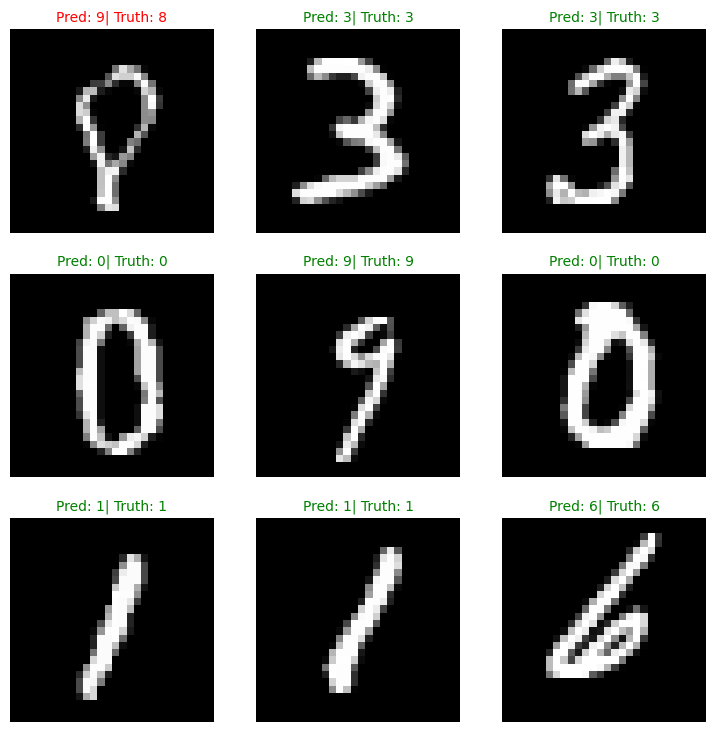

In [178]:
plt.figure(figsize=(9,9))
nrows, ncols = 3, 3
for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1)

    plt.imshow(sample.squeeze(), cmap='gray')

    pred_label = pred_classes[i]

    truth_label = test_labels[i]

    title_text = f"Pred: {pred_label}| Truth: {truth_label}"

    if pred_label==truth_label:
        plt.title(title_text, fontsize=10, c='g')
    else:
        plt.title(title_text, fontsize=10, c='r')
    plt.axis(False)

In [181]:

y_preds = []
pred_prob_lst = []
targets = []
model_0.eval()
from tqdm import tqdm
with torch.inference_mode():
    for batch, (X, y) in enumerate(test_dataloader):
        X = X.unsqueeze(dim=1).to(device).type(torch.float32)
        
        prob = model_0(X)
        targets.append(y)
        # preds = prob.argmax(dim=1)
        # preds = model_0(X)
        pred_prob_lst.append(prob)
        y_pred = prob.argmax(dim=1)

        y_preds.append(y_pred.cpu())

y_preds_all = torch.cat(y_preds)
y_preds_all

tensor([2, 7, 0,  ..., 2, 8, 6])

In [182]:
y_preds_all[:10]

tensor([2, 7, 0, 7, 2, 5, 5, 3, 8, 0])

In [162]:
targets = torch.cat(targets)

In [163]:
pred_prob_lst.shape[1]

10

In [87]:
prepared_test_data[0].shape

(28, 28)

In [183]:
sub_samp = pd.read_csv("/content/digit_recognizer/sample_submission.csv", index_col=0)
sub_samp.head()

,Label
ImageId,
1,0
2,0
3,0
4,0
5,0


In [184]:
main_test = []
with torch.inference_mode():
    for batch, X in enumerate(main_test_dataloader):
        X = X.unsqueeze(dim=1).to(device).type(torch.float32)
        
        prob = model_0(X)
        # preds = prob.argmax(dim=1)
        # preds = model_0(X)
        y_pred = prob.argmax(dim=1)

        main_test.append(y_pred.cpu())

main_test = torch.cat(main_test)
main_test

tensor([2, 0, 9,  ..., 3, 9, 2])

In [188]:
main_test[9]

tensor(3)

In [186]:
sub_samp['Label'] = main_test

In [189]:
sub_samp.head(11)

,Label
ImageId,
1,2
2,0
3,9
4,0
5,3
6,7
7,0
8,3
9,0


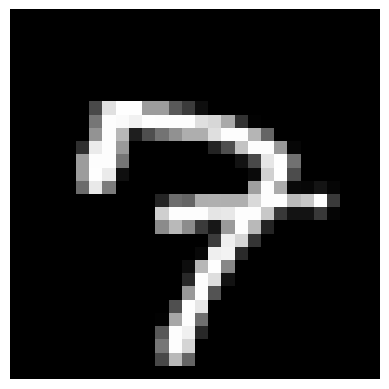

In [190]:
plt.imshow(prepared_test_data[5], cmap='gray')
plt.axis('off');

In [191]:
sub_samp.to_csv('submission_v3.csv', index=True)